**Tìm hiểu xem các yếu tố ảnh hưởng như nào đến các loại cây trồng**

In [58]:
# 1. THƯ VIỆN CẦN THIẾT
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb # Import XGBoost

import random
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from copy import deepcopy

In [49]:
df = pd.read_excel('Crop_recommendation.xlsx')

print(df.head())

df.info()

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [51]:
# Tạo cột 'Sum_NPK'
df['Sum_NPK'] = df[['N', 'P', 'K']].sum(axis=1)
print(df.head())

    N   P   K  temperature   humidity        ph    rainfall label  Sum_NPK
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice      175
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice      184
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice      159
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice      149
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice      162


In [52]:

def get_recommended_action(row):
    if row['N'] < 30 and row['K'] < 30: # Ví dụ: thiếu cả N và K
        return 'Add Fertilizer'
    if row['P'] < 20: # Ví dụ: thiếu P
        return 'Add Phosphorus'
    if row['rainfall'] < 100: # Lượng mưa thấp
        return 'Increase Watering'
    if row['humidity'] < 65: # Độ ẩm thấp
        return 'Provide More Humidity'
    if row['temperature'] > 35: # Nhiệt độ quá cao
        return 'Reduce Temperature' # Thêm một hành động mới
    if row['N'] > 80 and row['P'] > 50 and row['K'] > 50: # Mức dinh dưỡng tối ưu
        return 'Optimal Nutrient Levels'
    return 'No Specific Action' # Hành động mặc định

In [53]:
# Áp dụng các quy tắc để tạo cột hành động khuyến nghị
df['Recommended_Action'] = df.apply(get_recommended_action, axis=1)

# Mã hóa biến mục tiêu 'Recommended_Action' thành số
label_encoder = LabelEncoder()
df['Recommended_Action_Encoded'] = label_encoder.fit_transform(df['Recommended_Action'])

# Định nghĩa features (X) và target (y)
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'Sum_NPK']]
y = df['Recommended_Action_Encoded']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# stratify=y giúp đảm bảo tỷ lệ các lớp trong y_train và y_test tương tự nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa đặc trưng (Quan trọng cho KNN, và có thể giúp XGBoost một chút)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Chuyển đổi lại về DataFrame để giữ tên cột cho việc debug hoặc phân tích sau này
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

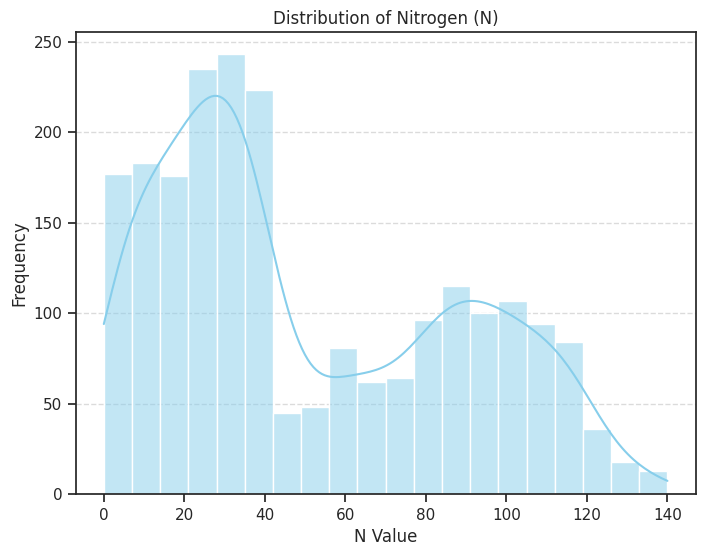

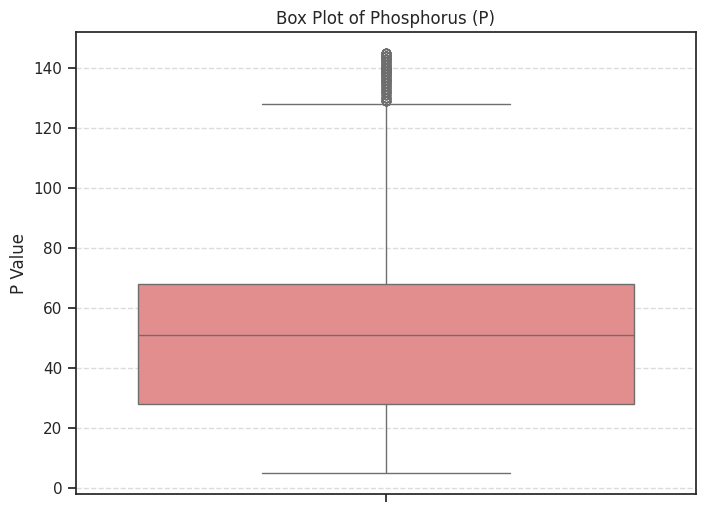

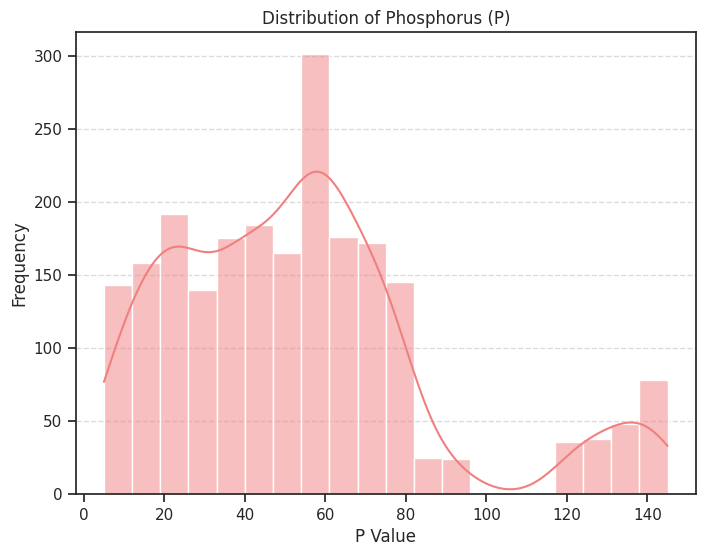

<Figure size 1500x1500 with 0 Axes>

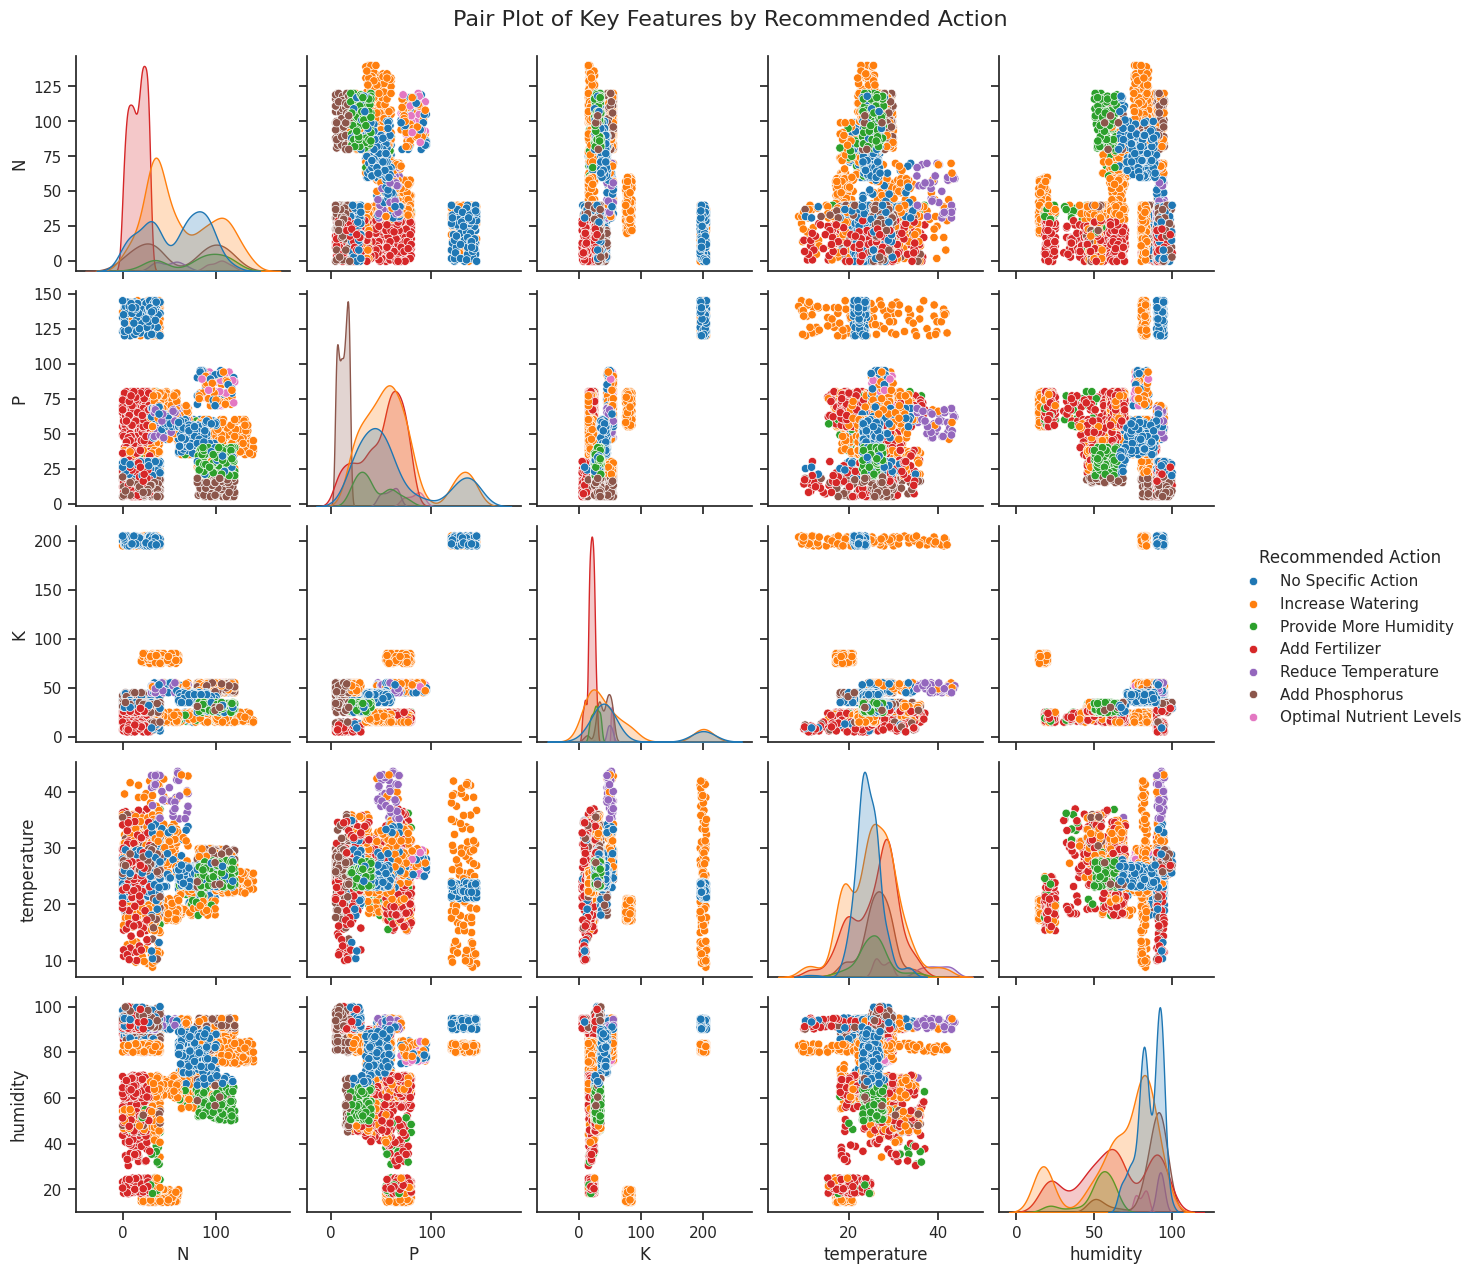

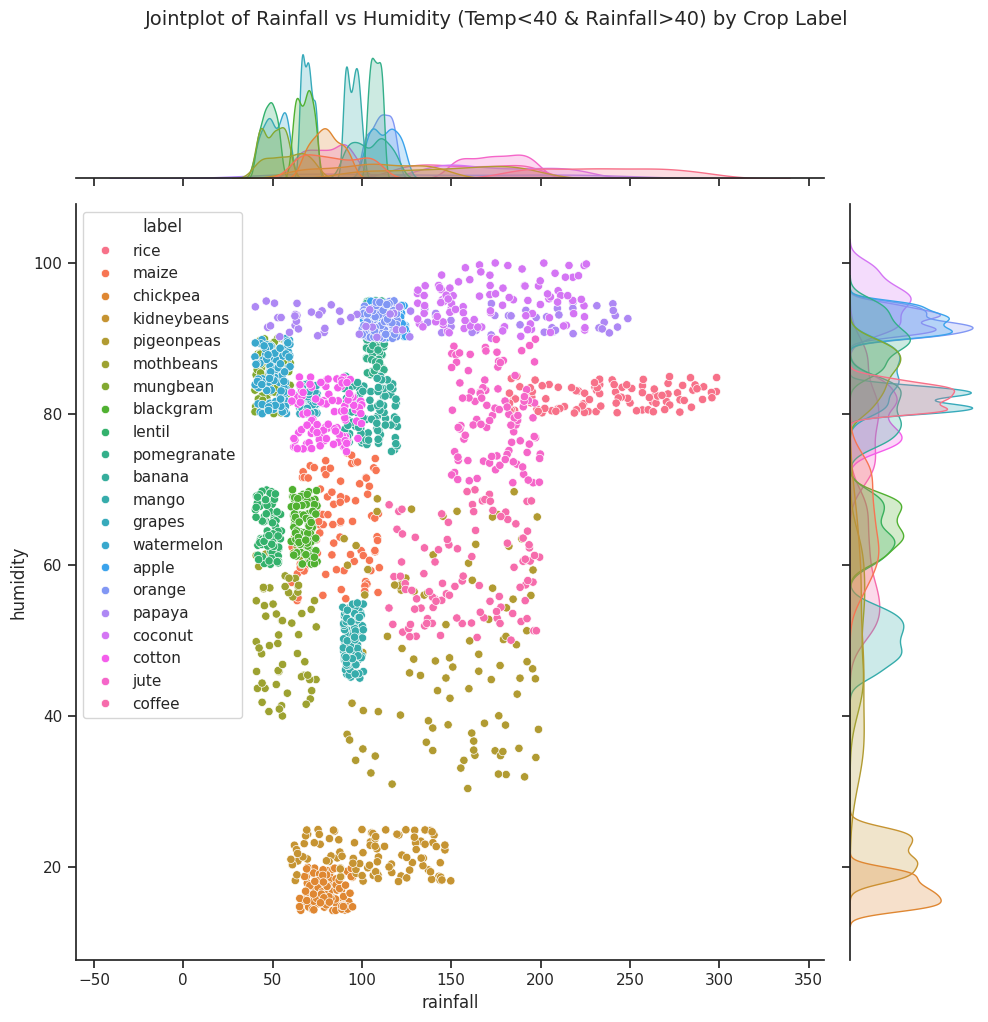

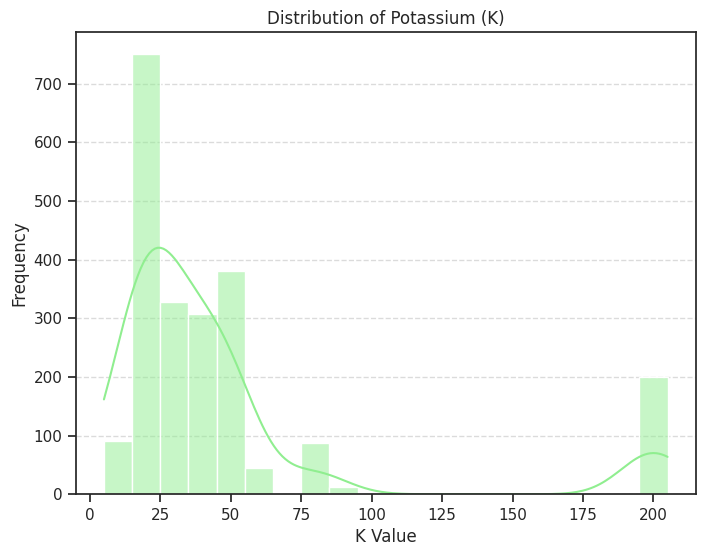


Correlation Heatmap của các đặc trưng số:


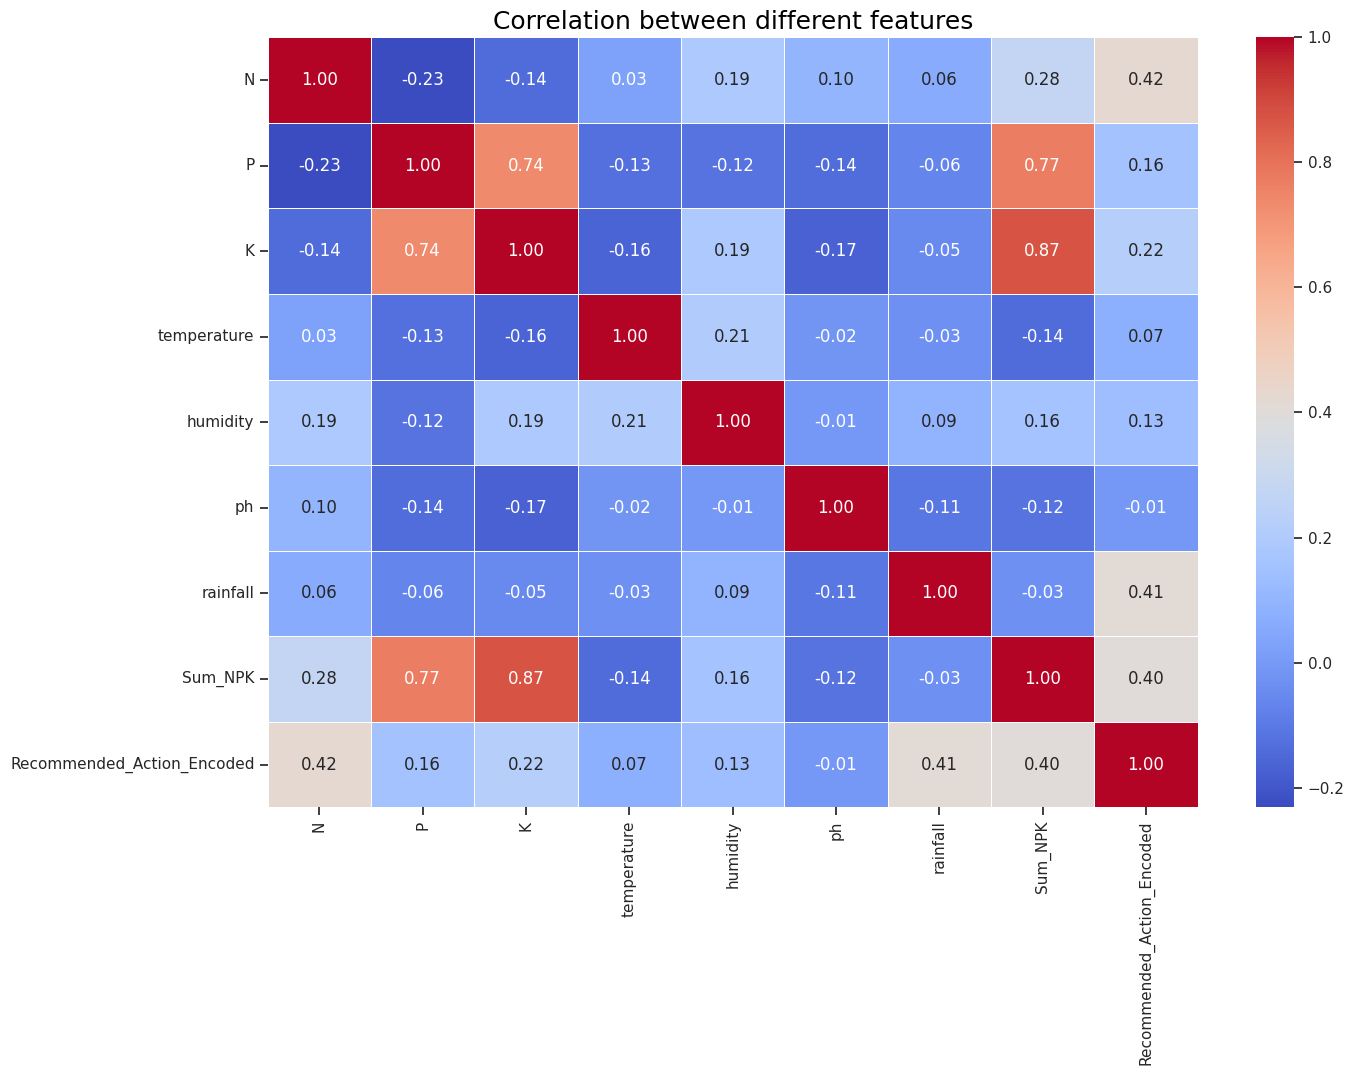

In [54]:
# 3.1. Histogram cho 'N'
plt.figure(figsize=(8, 6))
sns.histplot(df['N'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Nitrogen (N)')
plt.xlabel('N Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3.2. Box Plot cho 'P'
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['P'], color='lightcoral')
plt.title('Box Plot of Phosphorus (P)')
plt.ylabel('P Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3.3. Histogram cho 'P'
plt.figure(figsize=(8, 6))
sns.histplot(df['P'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Phosphorus (P)')
plt.xlabel('P Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3.4. Pair Plot cho các đặc trưng chính
sns.set(style="ticks")
# Sử dụng một bản sao của DataFrame để tránh SettingWithCopyWarning nếu có
df_for_pairplot = df[['N', 'P', 'K', 'temperature', 'humidity', 'Recommended_Action']].copy()
df_for_pairplot.rename(columns={'Recommended_Action': 'Recommended Action'}, inplace=True)

plt.figure(figsize=(15, 15)) # Tăng kích thước tổng thể của pairplot
sns.pairplot(df_for_pairplot, kind='scatter', hue='Recommended Action', palette='tab10', diag_kind='kde') # diag_kind='kde' cho mật độ ở đường chéo
plt.suptitle('Pair Plot of Key Features by Recommended Action', y=1.02, fontsize=16) # Đặt tiêu đề chung
plt.show()

# 3.5. Jointplot Rainfall vs Humidity (với điều kiện lọc)
jp = sns.jointplot(x="rainfall",y="humidity",data=df[(df['temperature']<40) &
                                                  (df['rainfall']>40)],height=10,hue="label")
jp.fig.suptitle('Jointplot of Rainfall vs Humidity (Temp<40 & Rainfall>40) by Crop Label', y=1.02, fontsize=14)
plt.show()

# 3.6. Histogram cho 'K'
plt.figure(figsize=(8, 6))
sns.histplot(df['K'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Potassium (K)')
plt.xlabel('K Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3.7. Correlation Heatmap
print("\nCorrelation Heatmap của các đặc trưng số:")
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation between different features', fontsize=18, color='black')
plt.show()



Bắt đầu huấn luyện XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:37:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}

--- XGBoost Classifier ---
Accuracy: 0.9068

Classification Report:
                         precision    recall  f1-score   support

         Add Fertilizer       0.88      0.94      0.91        97
         Add Phosphorus       0.94      0.88      0.91        57
      Increase Watering       0.91      0.95      0.93       133
     No Specific Action       0.92      0.93      0.92       107
Optimal Nutrient Levels       0.67      0.50      0.57         8
  Provide More Humidity       0.95      0.76      0.84        25
     Reduce Temperature       0.90      0.69      0.78        13

               accuracy                           0.91       440
              macro avg       0.88      0.81      0.84       440
           weighted avg       0.91      0.91      0.91       440



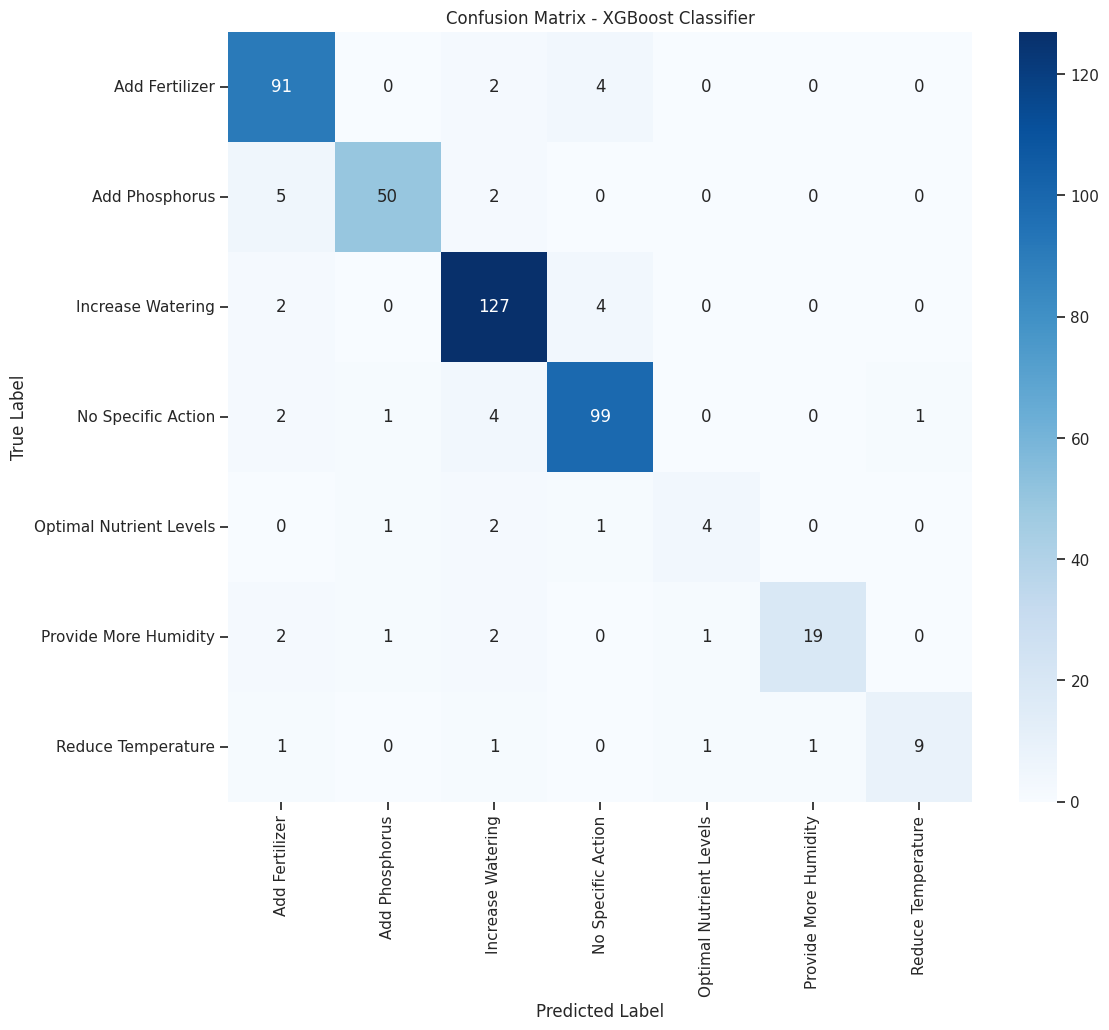

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
def inject_label_noise(y_labels, noise_level=0.1):
    y_noisy = deepcopy(y_labels)
    classes = list(set(y_labels))
    for i in range(len(y_noisy)):
        if random.random() < noise_level:
            y_noisy[i] = random.choice([cls for cls in classes if cls != y_noisy[i]])
    return y_noisy

y_noisy = inject_label_noise(y, noise_level=0.1)

# Tách tập train/test
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y_noisy, test_size=0.2, random_state=42
)
# --- 4.3. XGBoost Classifier ---
print("\nBắt đầu huấn luyện XGBoost Classifier...")

param_dist_xgb = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7, 8, 9], #
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.001, 0.005, 0.01], # L1 regularization
    'reg_lambda': [1, 1.5, 2, 2.5] # L2 regularization
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=num_classes,
                            eval_metric='mlogloss', # Metric cho phân loại đa lớp
                            use_label_encoder=False, # Để tránh cảnh báo
                            random_state=42)

randomized_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

randomized_search_xgb.fit(X_train_scaled, y_train)
best_params_xgb = randomized_search_xgb.best_params_
print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")

best_xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                                 num_class=num_classes,
                                 eval_metric='mlogloss',
                                 use_label_encoder=False,
                                 random_state=42,
                                 **best_params_xgb)
best_xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = best_xgb_clf.predict(X_test_scaled)
acc_xgb = evaluate_and_report_model("XGBoost Classifier", y_test, y_pred_xgb, target_names_for_report)
accuracies.append(acc_xgb)
model_names.append('XGBoost')